In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

current_dir = Path.cwd()


# 取得上一層目錄 (專案根目錄，例如 D:\NCKU\paper4)
project_root = current_dir.parent

# 把根目錄加入 Python 的搜尋路徑
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"已加入專案路徑: {project_root}")

to_delete = [m for m in sys.modules if m.startswith('src')]

for m in to_delete:
    del sys.modules[m]

print(f"已清理模組: {to_delete}")

import src.utils.data_loader as data_loader
import src.utils.helpers as helpers
import src.engine.trainer as trainer
import src.engine.evaluator as evaluator

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei']  # 解決中文亂碼
plt.rcParams['axes.unicode_minus'] = False


已加入專案路徑: d:\NCKU\paper4
已清理模組: []


In [2]:
# 硬體設定
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

# 資料與模型參數
DATASET_PATH = Path("../dataset/USD_TWD.csv")
HORIZON = 3  # 預測未來 3 天
LOOKBACK = 65  # 回看過去 30 天
NUM_EPOCHS = 100  # 訓練輪數
LR = 0.001  # 學習率
SEED = 42  # 固定種子
CNNEXPERT_KERNELSIZE = 5
SERIESDECOMPOSITION_KERNELSIZE = 7

Using Device: cuda


In [3]:
if not DATASET_PATH.exists():
    print(f"[Error]: Dataset not found at {DATASET_PATH}")
else:
    print("[Loading Data]")
    df = pd.read_csv(DATASET_PATH)

    # 呼叫 src 裡的函式
    train_loader, test_loader, scalers_raw, _, _, _, _ = data_loader.prepare_data(
        df, lookback=LOOKBACK, horizon=HORIZON
    )

    # 檢查一下 Batch
    sample = next(iter(train_loader))
    print(f"[Loading Data] Data Loaded! Train Batches: {len(train_loader)}, Test Batches: {len(test_loader)}")
    print(f"[Loading Data] Input Shape: {sample['raw_input'].shape}, Target Shape: {sample['target'].shape}")

[Loading Data]
[Loading Data] Data Loaded! Train Batches: 166, Test Batches: 40
[Loading Data] Input Shape: torch.Size([32, 65, 2]), Target Shape: torch.Size([32, 3])


In [4]:
print(f"[Training] Starting Training for {NUM_EPOCHS} epochs...")

helpers.set_seed(42)

model = trainer.train_v11(
    train_loader=train_loader,
    test_loader=test_loader,
    device=DEVICE,
    horizon=HORIZON,
    num_epochs=NUM_EPOCHS,
    lr=LR,
    seq_len=LOOKBACK,
    cnnExpert_KernelSize=CNNEXPERT_KERNELSIZE,
    seriesDecomposition_KernelSize=SERIESDECOMPOSITION_KERNELSIZE
)

print("[Training] Training Completed.")

[Training] Starting Training for 100 epochs...
Seed set to: 42 (Deterministic mode ON)

[Training] Enhanced DLinear...
  Epoch 20 | Loss: 0.4594 | Trend W: 0.000 | Seas W: 0.000
  Epoch 40 | Loss: 0.3785 | Trend W: 0.000 | Seas W: 0.000
  Epoch 60 | Loss: 0.3357 | Trend W: 0.000 | Seas W: 0.000
  Epoch 80 | Loss: 0.3093 | Trend W: 0.000 | Seas W: 0.000
  Epoch 100 | Loss: 0.2998 | Trend W: 0.000 | Seas W: 0.000
[Training] Training Completed.


In [6]:
print("[Evaluation] Running Evaluation...")

evaluator.evaluate_model(
    model=model,
    test_loader=test_loader,
    device=DEVICE,
    horizon=HORIZON
)

[Evaluation] Running Evaluation...

 FINAL MODEL EVALUATION (Horizon=3): Ablation Study (RevIN Enabled)
Metric               | Linear Base     | Base + CNN      | Improvement    
-----------------------------------------------------------------------------------------------
RMSE                 | 2.5208          | 1.7828          | -0.7380
R2 Score             | 0.5065          | 0.7532          | +0.2467
Avg Accuracy         | 0.5693          | 0.6917          | +0.1224
High Vol Accuracy    | 0.7279          | 0.8529          | +0.1250


{'RMSE_Final': np.float64(1.7827599132381515),
 'RMSE_Base': np.float64(2.5207779513073665),
 'R2_Final': 0.7531722784042358,
 'Avg_Acc': np.float64(0.6916666666666667),
 'High_Vol_Acc': np.float64(0.8528645833333334)}

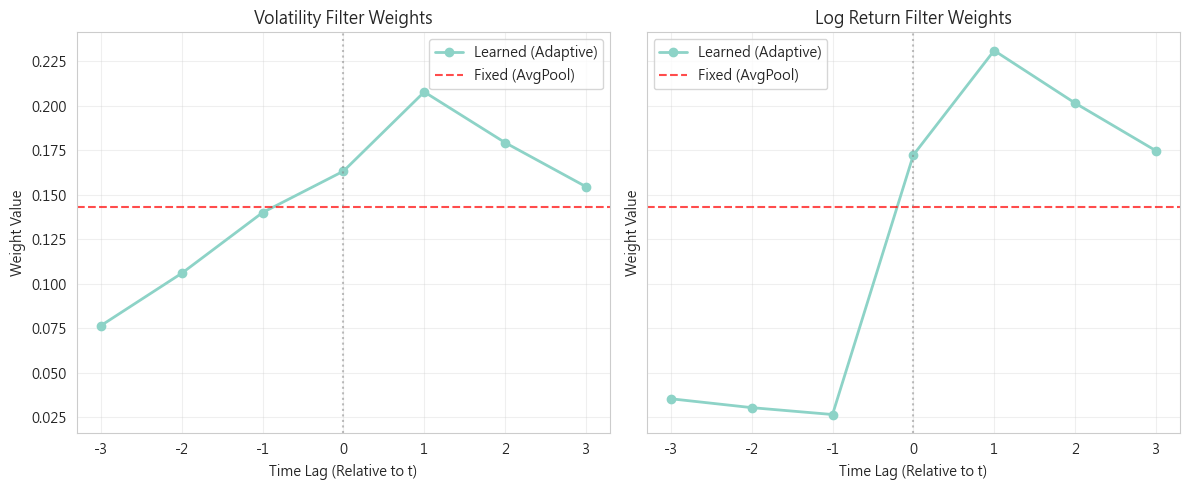

In [6]:
import matplotlib.pyplot as pltAAZ
import torch
import numpy as np


def visualize_learned_weights(model, kernel_size, feature_names=None):
    """
    繪製 Learnable Decomposition 的卷積權重

    Args:
        model: 訓練好的 EnhancedDLinear 模型
        kernel_size: 你設定的 SERIESDECOMPOSITION_KERNELSIZE (例如 11)
        feature_names: 特徵名稱列表，例如 ['Volatility', 'Log Return']
    """
    # 1. 提取權重
    # model.decomp.moving_avg.conv.weight 的形狀為 [Channels, 1, Kernel_Size]
    # 我們將其轉為 numpy array
    weights = model.decomp.moving_avg.conv.weight.data.cpu().numpy()

    num_channels = weights.shape[0]
    actual_kernel_size = weights.shape[2]

    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(num_channels)]

    # 2. 設定圖表
    fig, axes = plt.subplots(1, num_channels, figsize=(6 * num_channels, 5), sharey=True)
    if num_channels == 1:
        axes = [axes]

    # 初始的固定權重 (基準線) - 即 1/k
    fixed_weight_value = 1.0 / kernel_size

    # X 軸座標 (以中心為 0)
    # 因為是 Padding 模式，這代表相對於時間點 t 的偏移量
    x_axis = np.arange(actual_kernel_size) - (actual_kernel_size // 2)

    # 3. 繪製每個 Channel 的權重
    for i in range(num_channels):
        ax = axes[i]
        learned_w = weights[i, 0, :]

        # 畫出學習到的權重 (折線 + 點)
        ax.plot(x_axis, learned_w, marker='o', linewidth=2, label='Learned (Adaptive)')

        # 畫出初始固定權重 (虛線)
        ax.axhline(y=fixed_weight_value, color='r', linestyle='--', alpha=0.7, label='Fixed (AvgPool)')

        # 裝飾圖表
        ax.set_title(f'{feature_names[i]} Filter Weights')
        ax.set_xlabel('Time Lag (Relative to t)')
        ax.set_ylabel('Weight Value')
        ax.grid(True, alpha=0.3)
        ax.legend()

        # 標示中心點
        ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)

    plt.tight_layout()
    plt.show()


# === 使用範例 ===
# 假設你的 Kernel Size 是 11，且有兩個特徵
visualize_learned_weights(model, kernel_size=7, feature_names=['Volatility', 'Log Return'])